In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

In [3]:
from time import time

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [6]:
class ModelFullyConnected(nn.Module):

    def __init__(self, num_hidden=1, hidden_size=32, dropout_rate=0.5):
        super(ModelFullyConnected, self).__init__()
        assert num_hidden > 0
        self.input_size = (28, 28)
        self.output_size = 10
        self.num_hidden = num_hidden
        self.dropout_rate = dropout_rate
        self.input_layer = nn.Linear(self.input_size[0] * self.input_size[1], hidden_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, self.output_size)

    def forward(self, inputs):
        x = inputs.view(-1, self.input_size[0] * self.input_size[1])
        x = F.dropout(F.relu(self.input_layer(x)), p=self.dropout_rate)
        for layer in self.hidden_layers:
            x = F.dropout(F.relu(layer(x)), p=self.dropout_rate)
        x = self.output_layer(x)
        return F.log_softmax(x, dim=1)

In [7]:
class ModelConvolutional(nn.Module):

    def __init__(self, num_hidden=1, fc_hidden_size=32, dropout_rate=0.5, num_filters=16, filter_size=3):
        super(ModelConvolutional, self).__init__()
        assert num_hidden > 0
        self.input_size = (28, 28)
        self.output_size = 10
        self.num_hidden = num_hidden
        self.num_filters = num_filters
        self.dropout_rate = dropout_rate
        self.input_layer = nn.Conv2d(1, num_filters, filter_size)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden):
            self.hidden_layers.append(nn.Conv2d(num_filters, num_filters, filter_size))
        self.size_after_convs = (
            self.input_size[0] - (filter_size - 1) * (num_hidden + 1), 
            self.input_size[1] - (filter_size - 1) * (num_hidden + 1)
        )
        self.fc_layer = nn.Linear(self.size_after_convs[0] * self.size_after_convs[1] * num_filters, fc_hidden_size)
        self.output_layer = nn.Linear(fc_hidden_size, self.output_size)

    def forward(self, inputs):
        x = inputs.view(-1, 1, self.input_size[0], self.input_size[1])
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = x.view(-1, self.size_after_convs[0] * self.size_after_convs[1] * self.num_filters)
        #print(x.size())
        x = F.dropout(F.relu(self.fc_layer(x)), p=self.dropout_rate)
        #print(x.size())
        x = self.output_layer(x)
        #print(x.size())
        return F.log_softmax(x, dim=1)

In [24]:
class AdaSGD():
    
    def __init__(self, params, init_base_lr=0, meta_lr=1e-3, meta_betas=(0.9, 0.999), meta_eps=1e-8):
        self.params = list(params)
        self.base_lr_vectors = []
        self.grads = []
        for param in self.params:
            self.base_lr_vectors.append(nn.Parameter(torch.zeros_like(param.data) + init_base_lr))
            self.base_lr_vectors[-1].grad = torch.zeros_like(param)
            self.grads.append(torch.zeros_like(param.data))
            #print(type(self.grads[-1]), type(self.base_lr_vectors[-1].data))
        self.meta_opt = optim.Adam(self.base_lr_vectors, lr=meta_lr, betas=meta_betas, eps=meta_eps)
        
    def step(self):
        for i, param in enumerate(self.params):
            self.grads[i] += param.grad.data
            param.data = param.data - self.base_lr_vectors[i].data * param.grad.data 

    def meta_step(self):
        self.meta_opt.zero_grad()
        for i, param in enumerate(self.params):
            self.base_lr_vectors[i].grad.data = torch.clamp(-self.grads[i] * param.grad.data, -1, 1)
        self.meta_opt.step()
        for i, param in enumerate(self.params):
            self.base_lr_vectors[i].data.clamp_(1e-8, 1e1)
            self.grads[i] = torch.zeros_like(param.data)

In [71]:
batch_size = 256
test_batch_size = 32
max_epoch = 10
do_validation = False

In [72]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [11]:
losses = {}
test_losses = {}
times = {}
learning_rates = {}

In [12]:
Model = ModelFullyConnected
model_kwargs = {
    'num_hidden': 2, 
    'hidden_size': 256, 
    'dropout_rate': 0.8
}
model_name = '_'.join(['fc'] + [key + '=' + str(val) for key, val in model_kwargs.items()])
print(model_name)

fc_num_hidden=2_hidden_size=256_dropout_rate=0.8


In [13]:
losses[model_name] = {}
test_losses[model_name] = {}
times[model_name] = {}
learning_rates[model_name] = {}

In [45]:
torch.manual_seed(123)

#meta_opt_names = []

run_count = 3

meta_lr = 1e-2

for truncated_bptt_step in [500]:
    opt_name = 'AdaSGD' + '_bptt_steps=' + str(truncated_bptt_step) + '_meta_lr=' + str(meta_lr)
    print(opt_name)
    meta_opt_names.append(opt_name)
    
    losses[model_name][opt_name] = []
    test_losses[model_name][opt_name] = []
    times[model_name][opt_name] = []
    learning_rates[model_name][opt_name] = []
    
    for run in range(run_count):
        losses[model_name][opt_name].append([])
        test_losses[model_name][opt_name].append([])
        times[model_name][opt_name].append([])
        learning_rates[model_name][opt_name].append([])
        
        model = cuda_wrapper(Model(**model_kwargs))
        opt = AdaSGD(model.parameters(), init_base_lr=0.05, meta_lr=meta_lr)

        av_loss = 0
        av_test_loss = 0
        alpha = 0.999
        global_step = 0

        start_time = time()

        for epoch in range(max_epoch):
            epoch_start_time = time()
            for X, y in train_loader:
                X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                prob = model(X)
                loss = F.nll_loss(prob, y)
                model.zero_grad()
                do_meta_step = ((global_step + 1) % truncated_bptt_step == 0)
                if do_meta_step:
                    loss.backward(retain_graph=True)
                else:
                    loss.backward()
                opt.step()
                
                av_loss = alpha * av_loss + (1 - alpha) * loss.data[0]
                losses[model_name][opt_name][run].append(loss.data[0])
                
                if do_meta_step:
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                    model.zero_grad()
                    loss.backward()
                    opt.meta_step()
                    
                #learning_rates[model_name][opt_name][run].append(opt.base_lr.data[0])
                times[model_name][opt_name][run].append(time() - start_time)
                
                global_step += 1
                
            if do_validation:
                for X, y in test_loader:
                    X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                
                    av_test_loss = alpha * av_test_loss + (1 - alpha) * loss.data[0]
                    test_losses[model_name][opt_name][run].append(test_loss.data[0])

            print('epoch {} took {:.1f}s; av_loss = {:.3f}; av_test_loss = {:.3f}'.format(
                epoch+1, time() - epoch_start_time, av_loss, av_test_loss
            ))
            min_lr = 1e2
            max_lr = 0
            for lr_vec in opt.base_lr_vectors:
                min_lr = min(min_lr, torch.min(lr_vec.data))
                max_lr = max(max_lr, torch.max(lr_vec.data))
            print('min_lr = {:.3f}, max_lr = {:.3f}'.format(min_lr, max_lr))
        
        print()
        
    losses[model_name][opt_name] = np.array(losses[model_name][opt_name])
    test_losses[model_name][opt_name] = np.array(test_losses[model_name][opt_name])
    times[model_name][opt_name] = np.array(times[model_name][opt_name])
    #learning_rates[model_name][opt_name] = np.array(learning_rates[model_name][opt_name])


AdaSGD_bptt_steps=500_meta_lr=0.01
epoch 1 took 8.0s; av_loss = 0.193; av_test_loss = 0.000
min_lr = 0.020, max_lr = 0.080
epoch 2 took 7.8s; av_loss = 0.117; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.118
epoch 3 took 7.7s; av_loss = 0.078; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.145
epoch 4 took 7.6s; av_loss = 0.057; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.166
epoch 5 took 7.3s; av_loss = 0.044; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.184
epoch 6 took 8.3s; av_loss = 0.034; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.211
epoch 7 took 7.3s; av_loss = 0.028; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.232
epoch 8 took 13.6s; av_loss = 0.022; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.247
epoch 9 took 7.7s; av_loss = 0.018; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.250
epoch 10 took 7.5s; av_loss = 0.016; av_test_loss = 0.000
min_lr = 0.000, max_lr = 0.254
epoch 11 took 7.8s; av_loss = 0.017; av_test_loss = 0.000
min_lr = 0.000, max_lr = 

In [75]:
torch.manual_seed(123)

opt_names = []

run_count = 1

for lr in [0.05 / 64]:
    opt_name = 'SGD' + '_lr=' + str(lr)
    print(opt_name)
    opt_names.append(opt_name)
    
    losses[model_name][opt_name] = []
    test_losses[model_name][opt_name] = []
    times[model_name][opt_name] = []
    learning_rates[model_name][opt_name] = []
    
    for run in range(run_count):
        losses[model_name][opt_name].append([])
        test_losses[model_name][opt_name].append([])
        times[model_name][opt_name].append([])
        learning_rates[model_name][opt_name].append([])
        
        model = cuda_wrapper(Model(**model_kwargs))
        opt = optim.SGD(model.parameters(), lr=lr)

        av_loss = 0
        av_test_loss = 0
        alpha = 0.999
        global_step = 0
        
        old_grads = []
        old_grad_diffs = []
        grad_diffs_scalar_products = []

        start_time = time()
        
        for epoch in range(max_epoch):
            epoch_start_time = time()
            for X, y in train_loader:
                X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                prob = model(X)
                loss = F.nll_loss(prob, y)
                model.zero_grad()
                loss.backward()
                if old_grads:
                    grad_diffs_scalar_product = 0
                    for i, param in enumerate(model.parameters()):
                        grad_diffs = param.grad.data - old_grads[i]
                        grad_diffs_scalar_product += torch.sum(grad_diffs * old_grad_diffs[i])
                        old_grad_diffs[i].copy_(grad_diffs)
                        old_grads[i].copy_(param.grad.data)
                    grad_diffs_scalar_products.append(grad_diffs_scalar_product)
                else:
                    for i, param in enumerate(model.parameters()):
                        old_grad_diffs.append(torch.zeros_like(param.data))
                        old_grads.append(torch.zeros_like(param.data))
                        old_grads[-1].copy_(param.grad.data)
                opt.step()
                
                av_loss = alpha * av_loss + (1 - alpha) * loss.data[0]
                losses[model_name][opt_name][run].append(loss.data[0])
                
                learning_rates[model_name][opt_name][run].append(lr)
                times[model_name][opt_name][run].append(time() - start_time)
                
                global_step += 1
                
            if do_validation:
                for X, y in test_loader:
                    X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                
                    av_test_loss = alpha * av_test_loss + (1 - alpha) * loss.data[0]
                    test_losses[model_name][opt_name][run].append(test_loss.data[0])

            print('epoch {} took {:.1f}s; av_loss = {:.3f}; av_test_loss = {:.3f}; lr = {:.4f}'.format(
                epoch+1, time() - epoch_start_time, av_loss, av_test_loss, lr
            ))
        
        print()
        
    losses[model_name][opt_name] = np.array(losses[model_name][opt_name])
    test_losses[model_name][opt_name] = np.array(test_losses[model_name][opt_name])
    times[model_name][opt_name] = np.array(times[model_name][opt_name])
    learning_rates[model_name][opt_name] = np.array(learning_rates[model_name][opt_name])


SGD_lr=0.00078125
epoch 1 took 4.5s; av_loss = 0.482; av_test_loss = 0.000; lr = 0.0008
epoch 2 took 4.3s; av_loss = 0.861; av_test_loss = 0.000; lr = 0.0008
epoch 3 took 4.5s; av_loss = 1.158; av_test_loss = 0.000; lr = 0.0008
epoch 4 took 4.9s; av_loss = 1.391; av_test_loss = 0.000; lr = 0.0008
epoch 5 took 4.5s; av_loss = 1.571; av_test_loss = 0.000; lr = 0.0008
epoch 6 took 5.0s; av_loss = 1.710; av_test_loss = 0.000; lr = 0.0008


Process Process-614:
Traceback (most recent call last):
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/datasets/mnist.py", line 76, in __getitem__
    img = self.transform(img)


KeyboardInterrupt: 

  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 42, in __call__
    img = t(img)
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 61, in __call__
    return F.to_tensor(pic)
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/functional.py", line 76, in to_tensor
    return img.float().div(255)
KeyboardInterrupt


In [32]:
def running_average(a, alpha=0.999):
    #a = np.array(a)
    av = np.zeros_like(a)
    av[0] = a[0]
    for i in range(1, len(a)):
        av[i] = alpha * av[i-1] + (1 - alpha) * a[i]
    return av

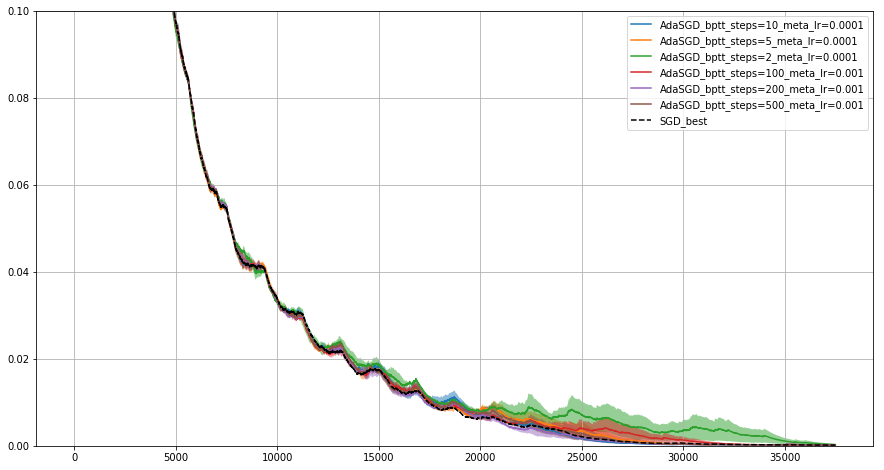

In [43]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    plt.plot(runs.mean(axis=1))
    plt.fill_between(
        np.arange(runs.shape[0]),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
for opt_name in ['SGD_lr=0.05']:
    runs = running_average(losses[model_name][opt_name].T)
    plt.plot(runs.mean(axis=1), 'k--')
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + ['SGD_best'])

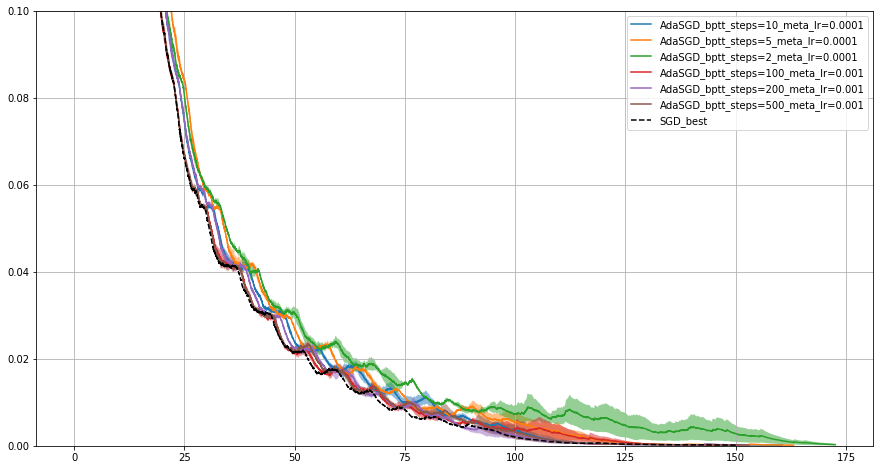

In [44]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1))
    plt.fill_between(
        time_runs.mean(axis=1),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
for opt_name in ['SGD_lr=0.05']:
    runs = running_average(losses[model_name][opt_name].T)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1), 'k--')
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + ['SGD_best'])

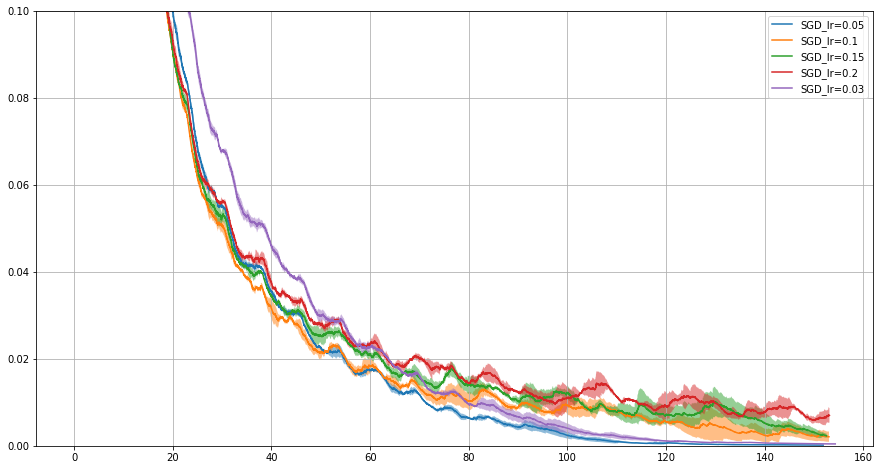

In [169]:
plt.figure(figsize=(15,8))
for opt_name in opt_names:
    runs = running_average(losses[model_name][opt_name].T)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1))
    plt.fill_between(
        time_runs.mean(axis=1),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(opt_names)

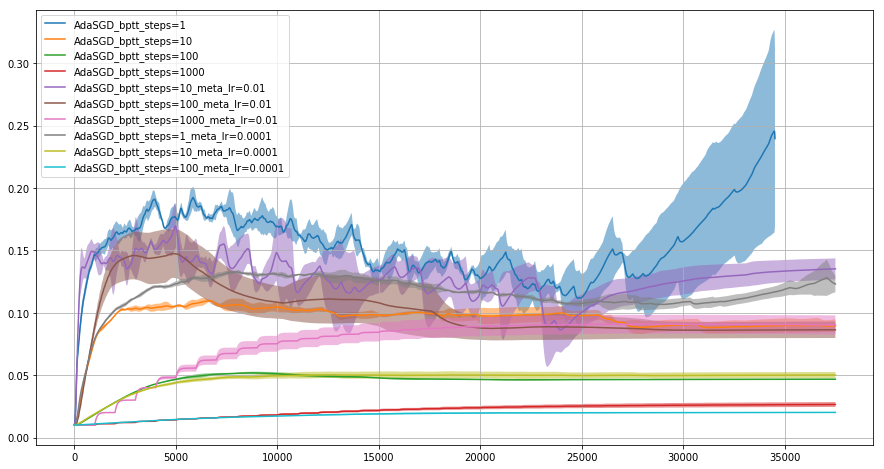

In [181]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names:
    runs = running_average(learning_rates[model_name][opt_name].T, alpha=0.99)
    plt.plot(runs.mean(axis=1))
    plt.fill_between(
        np.arange(runs.shape[0]),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
#plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names)

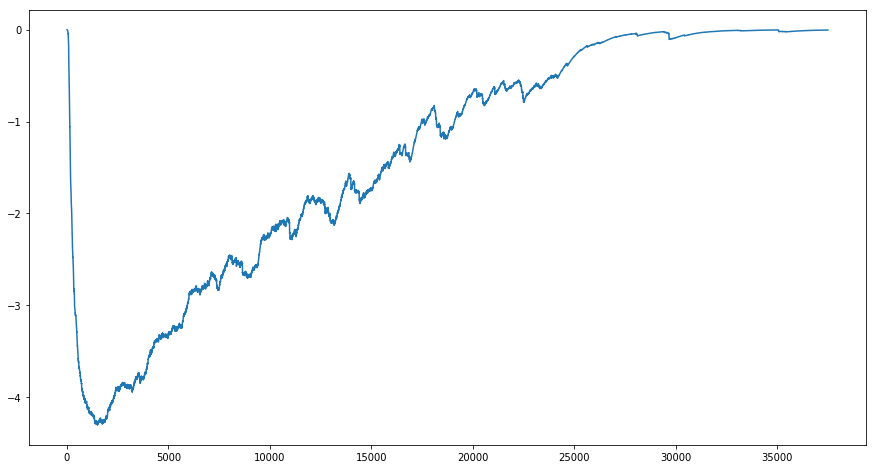

In [63]:
plt.figure(figsize=(15,8))
plt.plot(running_average(grad_diffs_scalar_products))